In [1]:
# here we're going to just try writing something from scratch

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# set up arrays
dx = 1000
x = np.arange(0, 100000, dx)
x_node = x + (dx/2)

Hstar = 0.5
etab = np.zeros(len(x)) # bedrock elevation, m
etab[:] = np.linspace(10, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x))
eta = etab + H

In [4]:
# set up parameters
K_ig = np.zeros(len(x))
K_ig[:24] = 1e-7
K_sed = np.zeros(len(x))
K_sed[24:] = 1e-6

beta_ig = np.zeros(len(x))
beta_ig[:24] = 4e-5
beta_sed = np.zeros(len(x))
beta_sed[24:] = 4e-4

# psi = np.zeros(len(x))
# psi[:14] = 4e-7
# psi[14:] = 4e-6
psi = 4e-5
gamma = 0.3

r = 10. # runoff rate
D = 0.015 # grain size
phi = 0.45 # porosity
baselevel_rate = 0.001 # baselevel fall rate

In [5]:
kqs = 0.041
I = 0.01
kxb = 25
Pxb = 1./5.
# Pxb = 1
kb = 8.3e-8

B_valley = kxb * (x_node**Pxb)
B_basin = (2./3.) * x_node

area = (1./3.) * x**2
# Q = r * x * B
Q = r * area

In [6]:
def model(x, dx, x_node,
          K_ig, K_sed, beta_ig, beta_sed,
          D, phi, Hstar, psi, gamma,
          kb, kqs, I, r, B_valley, B_basin, Q,
          etab, H, eta,
          baselevel_rate,
          num_steps = 1):
    
    q = Q/B_valley
    # dt = 0.2 * dx * dx / (kqs * q[-1]) # try changing to 10, 5, or 1 if this is unstable
    dt = 10.
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p_ig = np.zeros(len(x))
    Eb_p_sed = np.zeros(len(x))
    Eb_a_ig = np.zeros(len(x))
    Eb_a_sed = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    ql = np.zeros(len(x))
    
    H[-1] = 0
    E[-1] = baselevel_rate
    q[0] = 0
    Qs[0] = 0
    ql[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= baselevel_rate * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc Rh
#         width = (kb * Q[1:] * (S ** (7/6))) / (D**(3/2))
#         depth = (0.09801 * D) / S
#         Rh_efficiency = 1 - np.exp(-width/(2*depth))
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1]) # * Rh_efficiency
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p_ig[:-1] = K_ig[1:] * Q[1:] * S * alpha[:-1]
        Eb_p_sed[:-1] = K_sed[1:] * Q[1:] * S * alpha[:-1]
        Eb_a_ig[:-1] = beta_ig[1:] * Qs[1:] * alpha[:-1]
        Eb_a_sed[:-1] = beta_sed[1:] * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p_ig[:-1] + Eb_p_sed[:-1] + Eb_a_ig[:-1] + Eb_a_sed[:-1]) / B_valley[:-1]
        
        # calc grain attrition
        atr = Qs * psi
        
        # calc equilibrium lateral supply
        ql[1:24] = ((baselevel_rate * gamma) / psi) * (1 - np.exp(-psi/(3 * x[1:24])))
        ql[24:] = 0
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - Eb_p_ig[:-1] - ql[1:])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p_ig, Eb_p_sed, Eb_a_ig, Eb_a_sed, Eb, atr, ql, Eh, E, etab, H, eta)

In [7]:
#now write a test
num_steps = 750000
test_run = [x, dx, x_node, 
            K_ig, K_sed, beta_ig, beta_sed, 
            D, phi, Hstar, psi, gamma,
            kb, kqs, I, r, B_valley, B_basin, Q,
            etab, H, eta,
            baselevel_rate,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p_ig, Eb_p_sed, Eb_a_ig, Eb_a_sed, Eb, atr, ql, Eh, E, etab, H, eta) = model(*test_run)

7500000.0


In [8]:
dt

10.0

In [9]:
E

array([0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001])

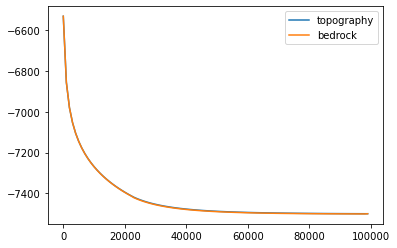

In [10]:
plt.plot(x, eta, label = "topography")
plt.plot(x, etab, label = "bedrock")
# plt.plot(x, H, label = "sediment")
plt.legend()

Text(0, 0.5, 'Bed exposure fraction (proxy for erosional efficiency)')

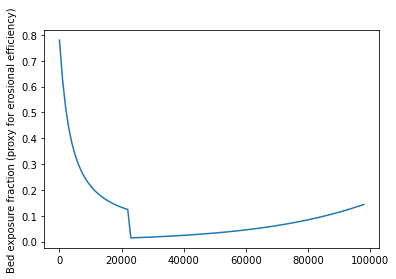

In [11]:
plt.plot(x[:-1], alpha[:-1])
plt.ylabel('Bed exposure fraction (proxy for erosional efficiency)')

In [12]:
S

array([3.23786432e-01, 1.23559323e-01, 7.30953632e-02, 5.15952864e-02,
       3.99012091e-02, 3.25863410e-02, 2.75801771e-02, 2.39337238e-02,
       2.11540307e-02, 1.89606201e-02, 1.71824537e-02, 1.57093870e-02,
       1.44673000e-02, 1.34044751e-02, 1.24837141e-02, 1.16775639e-02,
       1.09653095e-02, 1.03310167e-02, 9.76222048e-03, 9.24902332e-03,
       8.78346176e-03, 8.35905208e-03, 7.97045877e-03, 6.47407181e-03,
       5.83919411e-03, 5.28112201e-03, 4.78858881e-03, 4.35228121e-03,
       3.96444920e-03, 3.61860376e-03, 3.30928043e-03, 3.03185292e-03,
       2.78238491e-03, 2.55751155e-03, 2.35434383e-03, 2.17039109e-03,
       2.00349776e-03, 1.85179150e-03, 1.71364032e-03, 1.58761714e-03,
       1.47247017e-03, 1.36709821e-03, 1.27052982e-03, 1.18190575e-03,
       1.10046412e-03, 1.02552774e-03, 9.56493332e-04, 8.92822301e-04,
       8.34032788e-04, 7.79692848e-04, 7.29414538e-04, 6.82848804e-04,
       6.39681032e-04, 5.99627176e-04, 5.62430378e-04, 5.27858005e-04,
      

In [ ]:
eta

In [ ]:
# just for kicks
kb = 8.3e-8
b = (kb * Q[1:] * (S ** (7/6))) / (D**(3/2))
print(b)

In [ ]:
# ok really going out on a limb here...
depth = (0.09801 * D) / S
print(depth)

In [ ]:
plt.plot(S)

In [ ]:
S